In [2]:
# read in and plot data
import pandas as pd 
from pathlib import Path 

datapath = Path('data/easy_binary_classification_data.csv')
df = pd.read_csv(datapath, index_col=0)
df.head()

,X0,X1,y
0,-4.060008,7.242333,1.0
1,-2.445740,6.025199,1.0
2,-1.982058,4.642435,0.0
3,-3.816181,5.730205,1.0
4,-3.492723,4.322050,0.0


In [3]:
import numpy as np 
import torch 

np.random.seed(0)
torch.manual_seed(0)

X = torch.tensor(df[["X0", "X1"]].to_numpy(), dtype = torch.float32 )
y = torch.tensor(df.y.to_numpy(), dtype = torch.float32)
X.dtype, y.dtype

(torch.float32, torch.float32)

In [4]:
def log_Zp_expm(B, X = X, y = y, epsilon = 1, s=1, lam = .1): 
    """returns {util(B, X, y) epsilon/2s}
    Args:
        betas (torch.array): of shape [num_rows, 2] (every row gives a point in the plane.)
    Returns:
        w (torch.array): of shape [num_rows] with values for each 2d point in z. 
    """
    yl = torch.stack([ y ]*B.shape[0], 1)
    y_preds = torch.sigmoid(torch.mm(X,B.T)) # shape is (n by l): \phi(x^t b)  for each of the n data points x\in X, and for each of the l weight vectors b\in B, 
    # compute MSE: 
    losses = (y_preds - yl).pow(2) # shape is n by l (loss of all n data points for each of l betas)
    losses = losses.sum(0) #sum down the rows, should have shape [l]
    # regularization:
    regs = B.abs()
    regs = regs.sum(axis = 1) # shape is l
    # sum and negate to get utility: 
    util = - (losses + (lam * regs))
    # finally, we have the target potential function: 
    return  util * epsilon/(2*s) 

def Zp_expm(B, X = X, y = y, epsilon = 1, s=1, lam = .1): 
    return torch.exp(log_Zp_expm(B, X, y, epsilon, s, lam) )


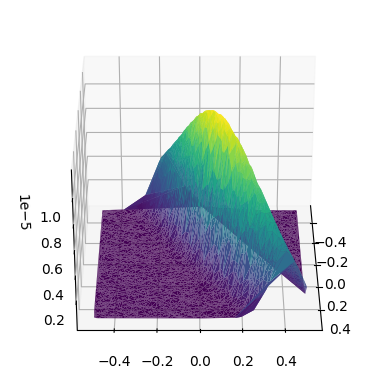

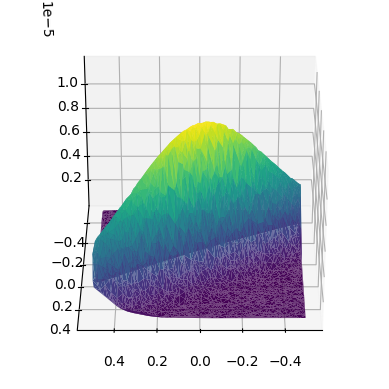

In [5]:
## Let's look at p_expm!!
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

B = torch.FloatTensor(5000,2).uniform_(-.5,.5)
Zp = Zp_expm(B)
# B.shape, Zp.shape

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(B[:,0], B[:,1], Zp, cmap=plt.cm.viridis, linewidth=0.2)
ax.view_init(30, 0)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(B[:,0], B[:,1], Zp, cmap=plt.cm.viridis, linewidth=0.2)
ax.view_init(30, 90)
plt.show()

In [6]:
## Train NF to approximately sample from p_expm
import sys
sys.path.append( Path(Path.cwd(), "code").as_posix() )
from normalizing_flows import *


class LR_no_bias(torch.nn.Module): 
    """
    A basic logistic regression module.
    """
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs


def loss_nf(samples, model, X, yl,  epsilon, lam = .1): 
    """reverse KL loss for training NF model to optimize the logistic regression via its l2 loss function
    Args:
        samples (torch.tensor): random_normal_samples() output
        model (NormalizingFlow): NF model
        X (torch.tensor): X_train (without an extra column of ones usually for bias term)
        yl (torch.tensor): y_training * batchsize
        wl (torch.tensor): weights_training * batchsize
        epsilon (float): privacy parameter
        lam (float): regularization constant (see config.py, nf_c)
    Returns:
        (float): reverseKL loss from target potential e^{-L2_loss * epsilon/2s}
    """    
    s = 1
    # print(samples.get_device())
    B, log_det_T = model(samples) # we need the log_det_T and the x_i = T(u_i)
    y_preds = torch.sigmoid(torch.mm(X,B.T)) # shape is (n by l): \phi(x^t b)  for each of the n data points x\in X, and for each of the l weight vectors b\in B, 
    # compute MSE: 
    losses = (y_preds - yl).pow(2) # shape is n by l (loss of all n data points for each of l betas)
    losses = losses.sum(0) #sum down the rows, should have shape [l]
    # regularization:
    regs = B.abs()
    regs = regs.sum(axis = 1) # shape is l
    # sum and negate to get utility: 
    util_l2 = - (losses + (lam * regs))
    # finally, we have the target potential function: 
    log_p_x = util_l2 * epsilon/(2*s)
    # and can combine into the loss: 
    loss = -( log_det_T.squeeze() + log_p_x).mean() # Reverse KL
    return loss


In [7]:
## params for training: 
epochs = 100
batch_size = 500
lr = 0.01
momentum = .5
lam = .1
sample_std = 0.01
n_flows = 2
epsilon = 1
patience = 15 

verbose = True 
skip = 5

yl = torch.stack([ y ]*batch_size, 1) # make labels for every batch's y_pred values

dim = X.shape[1] ## no bias term! 

In [8]:
# instantiate model and train
model = NormalizingFlow(dim, n_flows=n_flows) # number of layers/flows = n_flows

opt = torch.optim.RMSprop(\
    params = model.parameters(),\
    lr = lr,\
    momentum = momentum)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=patience, verbose=verbose) 


In [9]:
steps = []
losses = []
for epoch in range(1, epochs+1):
    # samples = random_normal_samples(batch_size, dim = model.dim) # {u_i} sampled from base. 
    samples = random_normal_samples(batch_size, dim = model.dim, std = sample_std, device = "cpu")
    loss = loss_nf(samples, model, X, yl, epsilon, lam = lam)    
    # take a step: 
    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)
    # Store/print loss values: 
    if epoch % skip == 0: 
        steps.append(epoch)
        losses.append(loss.item())
        if verbose: print(f'Epoch {epoch}\t loss {losses[-1]}')

Epoch 5	 loss 11.179363250732422
Epoch 10	 loss 10.824114799499512
Epoch 15	 loss 10.354427337646484
Epoch 20	 loss 10.170136451721191
Epoch 25	 loss 10.014981269836426
Epoch 30	 loss 9.84948444366455
Epoch 35	 loss 9.659732818603516
Epoch 40	 loss 9.489126205444336
Epoch 45	 loss 9.223864555358887
Epoch 50	 loss 8.919327735900879
Epoch 55	 loss 8.663928985595703
Epoch 60	 loss 8.459568977355957
Epoch 65	 loss 8.293286323547363
Epoch 70	 loss 8.20646858215332
Epoch 75	 loss 8.059944152832031
Epoch 80	 loss 7.966940879821777
Epoch 85	 loss 7.8872785568237305
Epoch 90	 loss 7.764834880828857
Epoch 95	 loss 7.721274375915527
Epoch 100	 loss 7.66814661026001


In [10]:
# prepare for ploting the NF output density & expm density together 
B = torch.FloatTensor(5000,2).uniform_(-.05,.05)    

## for base normal density:
loc = torch.zeros((1,2))
var = (sample_std**2) * torch.eye(2)
p_z = torch.distributions.multivariate_normal.MultivariateNormal(loc, covariance_matrix=var) 

with torch.no_grad():
    betas, log_det_J = model.forward(B)
    p_betas = torch.exp(p_z.log_prob(B) - log_det_J.squeeze())
    ## math is: p_betas = p_z(B)/det(J_T(b)), p_z(b) is from N(0,sample_std^2I), det(J_T(b)) = exp(log_det_j)

## and the "real" density's values for these inputs
Zp = Zp_expm(betas)

## best fit Z^{-1} to make these two densities close in l2 sense: 
## minimize l2 loss function for constant Z_inv: 
l = lambda c: ((c*Zp - p_betas)**2).sum()
Z_inv = ((Zp * p_betas).sum())/(( (Zp**2).sum() ))
p_exp = Z_inv * Zp
print(f"l2 loss of estimated Z: {l(Z_inv)/len(Zp)}")
print(f"l2 estimated Z: (1/Z_inv) = {1/Z_inv}")

## approx Z via sampling: E_q(Zp(t)/q(t)) = Z
## we have betas sampled from q, and w = Zp/p_betas: 
Z_w = torch.exp(torch.log(Zp) - torch.log(p_betas) ).mean()
print(f"sampling mean estimated Z: Z_w = {Z_w}")

l2 loss of estimated Z: 8.51115608215332
l2 estimated Z: (1/Z_inv) = 1.37905340125144e-06
sampling mean estimated Z: Z_w = 2.9434807300567627


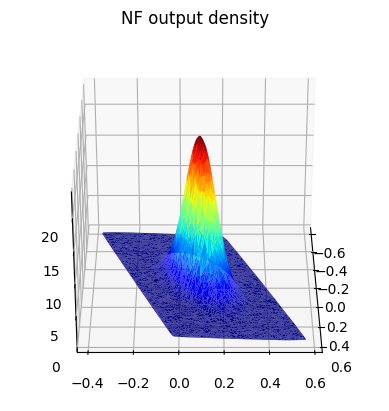

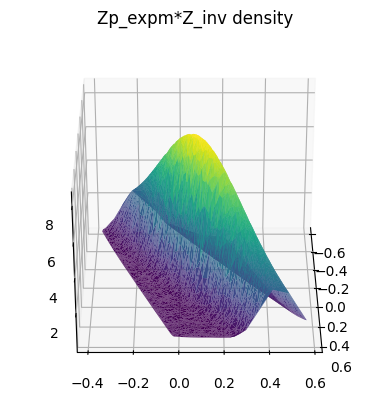

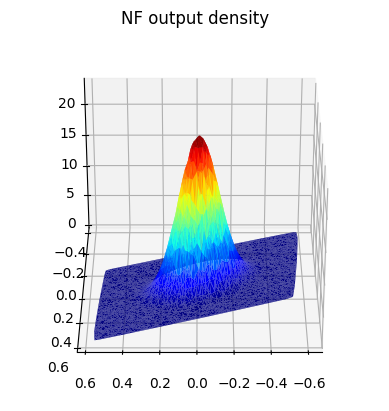

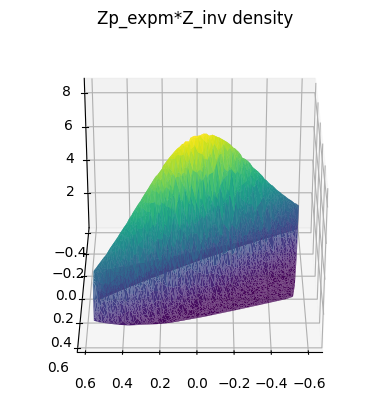

In [11]:
## Plots with Z_inv, found w/ L2 loss of samples: 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(betas[:,0], betas[:,1], p_betas, cmap=plt.cm.jet, 
                linewidth=0.2)
ax.view_init(30, 0)
ax.set_title('NF output density')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(betas[:,0], betas[:,1], Zp*Z_inv, cmap=plt.cm.viridis, 
                linewidth=0.2)
ax.set_title('Zp_expm*Z_inv density')
ax.view_init(30, 0)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(betas[:,0], betas[:,1], p_betas, cmap=plt.cm.jet, 
                linewidth=0.2)
ax.set_title('NF output density')
ax.view_init(30, 90)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(betas[:,0], betas[:,1], Zp*Z_inv, cmap=plt.cm.viridis, 
                linewidth=0.2)
ax.set_title('Zp_expm*Z_inv density')
ax.view_init(30, 90)



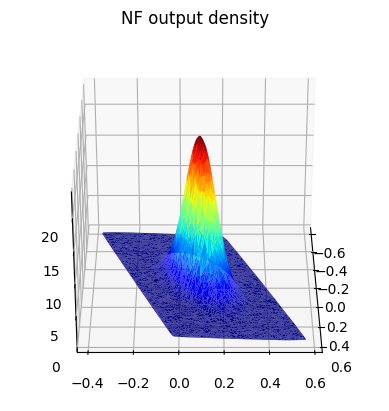

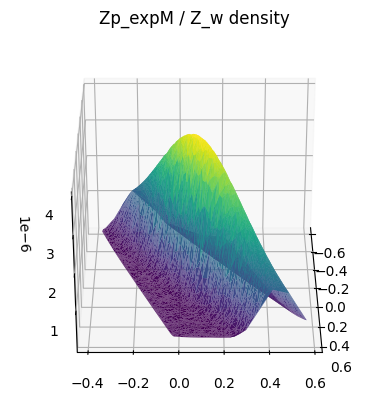

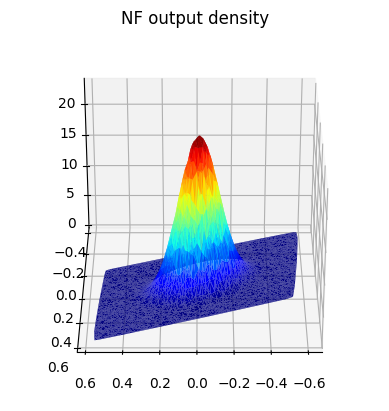

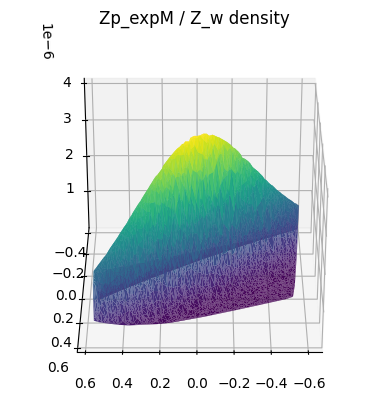

In [12]:
## Plots with Z_w, found w/ L2 loss of samples: 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(betas[:,0], betas[:,1], p_betas, cmap=plt.cm.jet, 
                linewidth=0.2)
ax.view_init(30, 0)
ax.set_title('NF output density')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(betas[:,0], betas[:,1], Zp/Z_w, cmap=plt.cm.viridis, 
                linewidth=0.2)
ax.set_title('Zp_expM / Z_w density')
ax.view_init(30, 0)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(betas[:,0], betas[:,1], p_betas, cmap=plt.cm.jet, 
                linewidth=0.2)
ax.view_init(30, 90)
ax.set_title('NF output density')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(betas[:,0], betas[:,1], Zp/Z_w, cmap=plt.cm.viridis, 
                linewidth=0.2)
ax.set_title('Zp_expM / Z_w density')
ax.view_init(30, 90)
plt.show()



In [13]:
df = pd.DataFrame({"x": betas[:,0].tolist(), "y": betas[:,1].tolist(), 
              "Zp": Zp.tolist(), "Zp*Z_inv": (Z_inv*Zp).tolist(),
              "Zp/Z_w": (Zp/Z_w).tolist() , "q": p_betas.tolist()}).sort_values(["x", "y"])
df.describe()

,x,y,Zp,Zp*Z_inv,Zp/Z_w,q
count,5000.000000,5000.000000,5.000000e+03,5000.000000,5.000000e+03,5.000000e+03
mean,-0.007032,0.096330,2.556749e-06,1.853988,8.686142e-07,1.444205e+00
std,0.328954,0.205541,3.082131e-06,2.234961,1.047104e-06,3.854831e+00
min,-0.591070,-0.378724,1.253983e-10,0.000091,4.260204e-11,6.183891e-10
25%,-0.292901,-0.060645,1.134970e-07,0.082301,3.855877e-08,1.477120e-04
50%,-0.000935,0.096419,1.108620e-06,0.803899,3.766357e-07,8.356467e-03
75%,0.281352,0.250857,4.349319e-06,3.153844,1.477611e-06,4.406566e-01
max,0.560095,0.564154,1.193283e-05,8.652915,4.053987e-06,2.360993e+01


In [14]:
 ## q is way smaller on the boundary of the square
df, df.sort_values(["y", "x"])

(             x         y            Zp  Zp*Z_inv        Zp/Z_w             q
 1208 -0.591070 -0.319861  1.171896e-06  0.849783  3.981326e-07  4.909448e-08
 2645 -0.588835 -0.289153  2.038424e-06  1.478133  6.925217e-07  3.173936e-07
 4683 -0.588671 -0.320023  1.145611e-06  0.830723  3.892029e-07  5.177287e-08
 3089 -0.588619 -0.361163  4.105001e-07  0.297668  1.394608e-07  2.970938e-09
 4016 -0.587655 -0.276331  2.439458e-06  1.768937  8.287664e-07  6.443745e-07
 ...        ...       ...           ...       ...           ...           ...
 2943  0.556758  0.412111  4.041734e-06  2.930803  1.373114e-06  6.348640e-06
 2634  0.557160  0.478720  3.887032e-06  2.818623  1.320556e-06  2.718228e-07
 4513  0.557273  0.428486  4.271961e-06  3.097749  1.451330e-06  3.262028e-06
 1016  0.558482  0.518425  2.842194e-06  2.060975  9.655896e-07  2.138272e-08
 1302  0.560095  0.483924  3.783286e-06  2.743393  1.285310e-06  1.845963e-07
 
 [5000 rows x 6 columns],
              x         y           

In [16]:
## q is way bigger in the middle of the square
df_q = df.sort_values(["q"], ascending=False)
best_beta_from_q = df_q.iloc[0][["x", "y"]]
df_q

,x,y,Zp,Zp*Z_inv,Zp/Z_w,q
3865,-0.009127,0.096894,1.184143e-05,8.586634,4.022933e-06,2.360993e+01
3020,-0.016765,0.089072,1.190354e-05,8.631676,4.044036e-06,2.351716e+01
2860,0.007684,0.107958,1.180298e-05,8.558756,4.009872e-06,2.320283e+01
1048,-0.036777,0.087895,1.152434e-05,8.356706,3.915210e-06,2.296447e+01
1523,-0.034019,0.080277,1.183280e-05,8.580380,4.020003e-06,2.294581e+01
...,...,...,...,...,...,...
4286,-0.536029,0.205125,5.430934e-09,0.003938,1.845072e-09,8.054876e-10
3552,0.510692,-0.030691,1.253983e-10,0.000091,4.260204e-11,7.676303e-10
2903,0.554920,0.564154,1.589734e-06,1.152772,5.400864e-07,7.083662e-10
1148,-0.537781,0.205395,5.322154e-09,0.003859,1.808116e-09,6.877254e-10
